In [1]:
# Artificial Neural Network

### Importing the libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Importing the dataset

In [3]:
dataset = pd.read_csv('Churn_Modelling.csv')

# Exploratory Data Analysis

In [4]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
dataset.shape

(10000, 14)

In [6]:
dataset.describe().T.style.bar(
    subset=['mean'],
    color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.000000,5000.500000,2886.895680,1.000000,2500.750000,5000.500000,7500.250000,10000.000000
CustomerId,10000.000000,15690940.569400,71936.186123,15565701.000000,15628528.250000,15690738.000000,15753233.750000,15815690.000000
CreditScore,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
Age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
Tenure,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,10000.000000,76485.889288,62397.405202,0.000000,0.000000,97198.540000,127644.240000,250898.090000
NumOfProducts,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
HasCrCard,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000
IsActiveMember,10000.000000,0.515100,0.499797,0.000000,0.000000,1.000000,1.000000,1.000000
EstimatedSalary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000


In [7]:
dataset.isnull().values.any()

False

## Plotting Count for Qualities

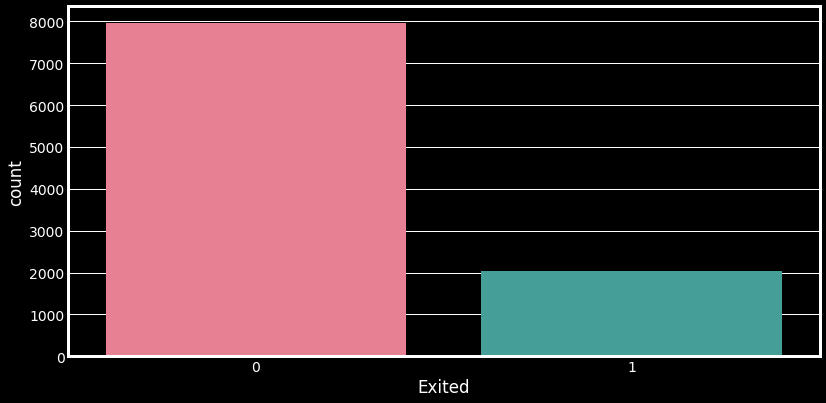

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x="Exited", data=dataset, palette='husl');

## Some BoxPlots

In [9]:
def boxPlotter(columnName):
        sns.catplot(x="Exited", y=columnName, data=dataset, kind="box");

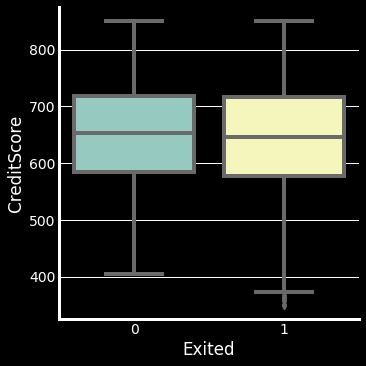

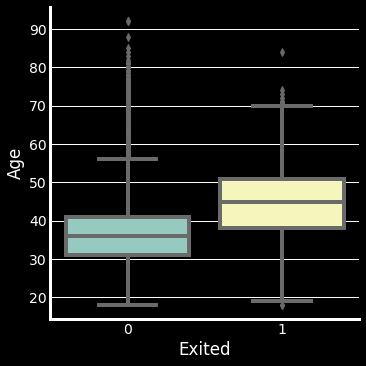

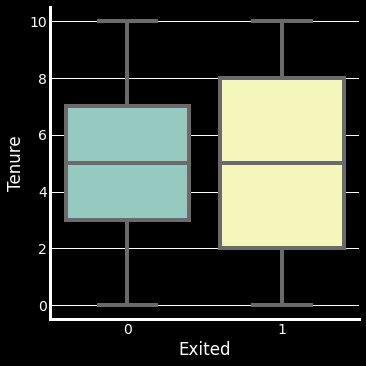

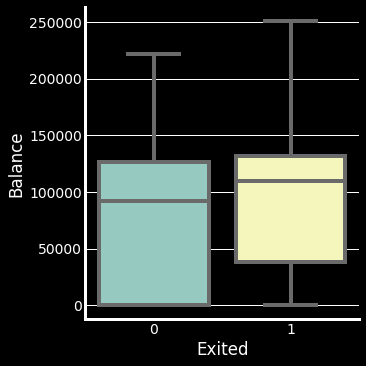

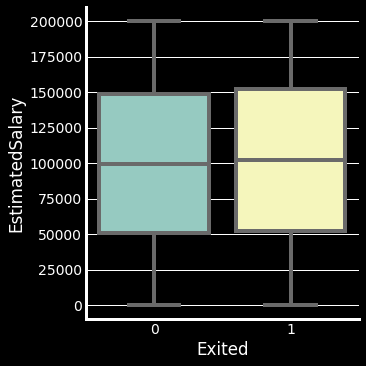

In [10]:
cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
for column in cols:
    boxPlotter(column)

From above Plots we can conclude that:-
1. There is no significant difference in credit score distribution between customers which are churned or not.
1. The older customers are churning more than younger ones.
1. Bank is loosing customers with significant bank balance.
1. Estimated Salary does not have a significant on the likelihood to churn.
Interestingly, majority of customers that churned are those with credit cards but this can be a coincidence as majority of customers have credit cards.
Unsurprisingly the inactive members have a greater churn and the overall proportion of inactive members is also very high.

## Correlation Plot

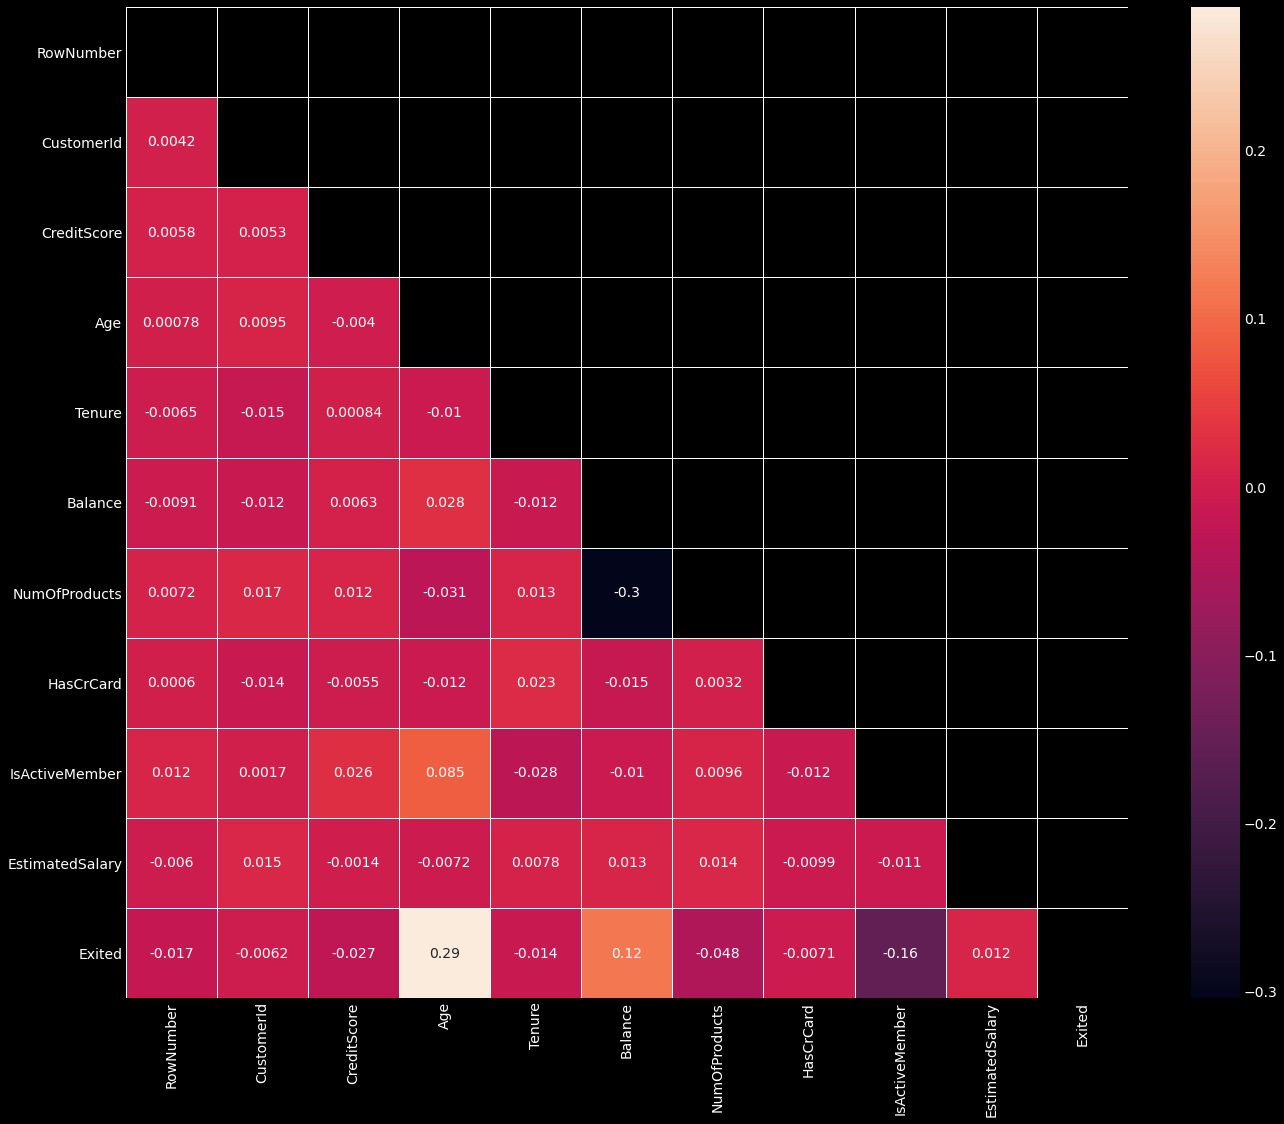

In [11]:
plt.figure(figsize=(20, 17))
matrix = np.triu(dataset.corr())
sns.heatmap(dataset.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

## From above correlation plot we can say that there is no multicolinearity present in data

## Some PieCharts

In [12]:
plot_data =  dataset.drop(['RowNumber', 'CustomerId', 'Surname','Gender','NumOfProducts', 'HasCrCard','Geography',
       'IsActiveMember', ], axis=1)

In [13]:
def pieChartPlotter(dataset, columnName):
    values = dataset[columnName].value_counts()
    labels = dataset[columnName].unique()
    pie, ax = plt.subplots(figsize=[10, 6])

    patches, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.2f%%', shadow=True, pctdistance=.5,# explode=[0.06]*dataset['Exited'].unique()
                                       )

    plt.legend(patches, labels, loc="best")
    plt.title(columnName, color='white', fontsize=14)
    plt.setp(texts, color='white', fontsize=20)
    plt.setp(autotexts, size=10, color='black')
    autotexts[1].set_color('black')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

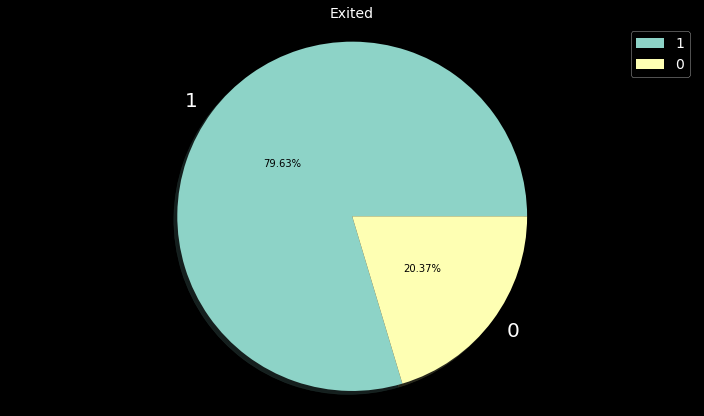

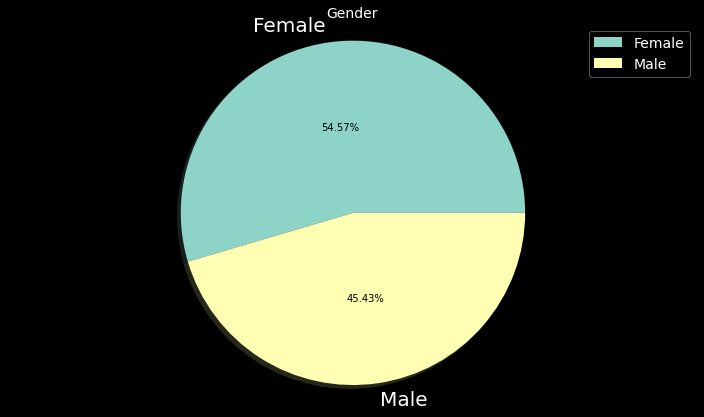

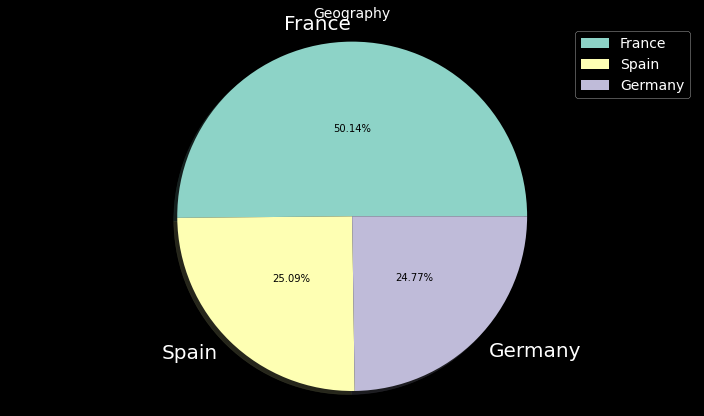

In [14]:
pieChartPlotter(dataset, 'Exited') 
pieChartPlotter(dataset, 'Gender')
pieChartPlotter(dataset, 'Geography')

### From Above plot
1. We can see that 79.63% of customers have churned out 
1. There are 54.57% Males and 45.43% females
1. About 50.14% customers are from France, 25.09% from Spain and 24.77% from germany

## Group Plots

In [15]:
def groupBarPlotter(dataset):
    """
    Group Plots columns with Exited column
    """
    fig = plt.figure(figsize=(20, 30))
    for i in range(len(dataset.columns)):
        if not dataset.columns[i] == 'Exited':
            groups = dataset.groupby(dataset.columns[i])['Exited'].mean()
            fig.add_subplot(np.ceil(len(dataset.columns)/2), 2, i+1)
            plt.xlabel('price')
            groups.plot.barh()
            fig.tight_layout(pad=3.0)

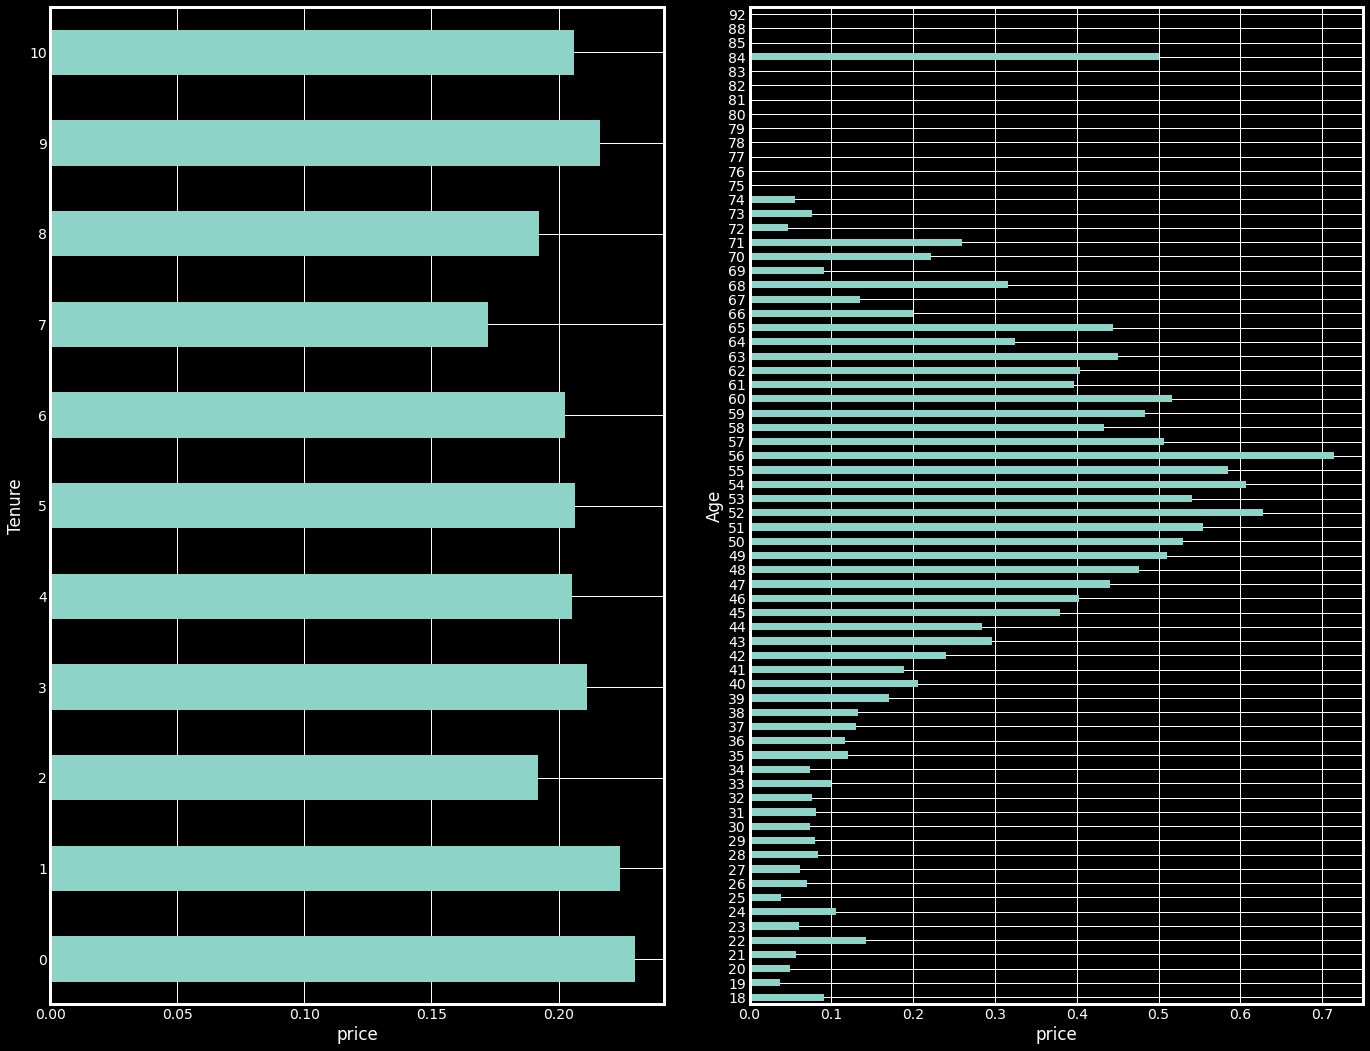

In [16]:
groupBarPlotter(dataset.loc[:, ['Tenure', 'Age','Exited']])

## Distribution Plot

In [17]:
def distributionPlot(dataset):
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(dataset.columns)):
        fig.add_subplot(np.ceil(len(dataset.columns)/5), 3, i+1)
        sns.distplot(
            dataset.iloc[:, i], color="lightcoral", rug=True)
        fig.tight_layout(pad=3.0)

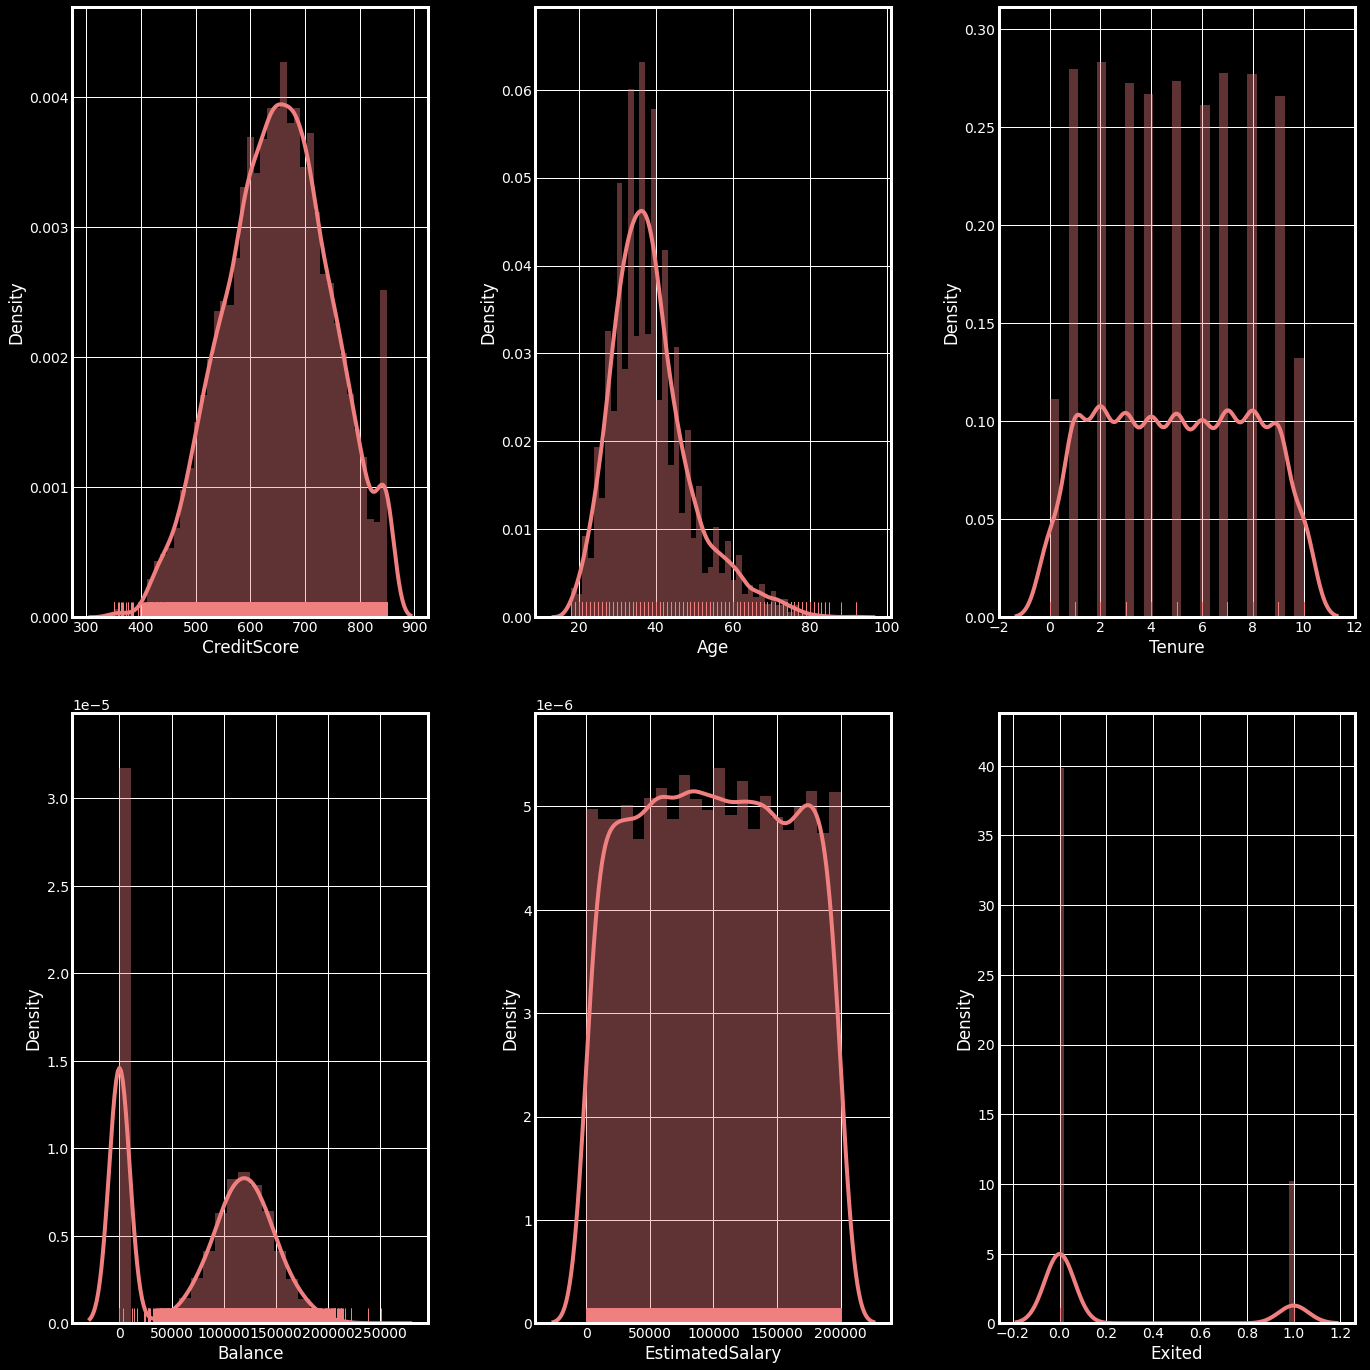

In [18]:
distributionPlot(plot_data)

## Pairplots

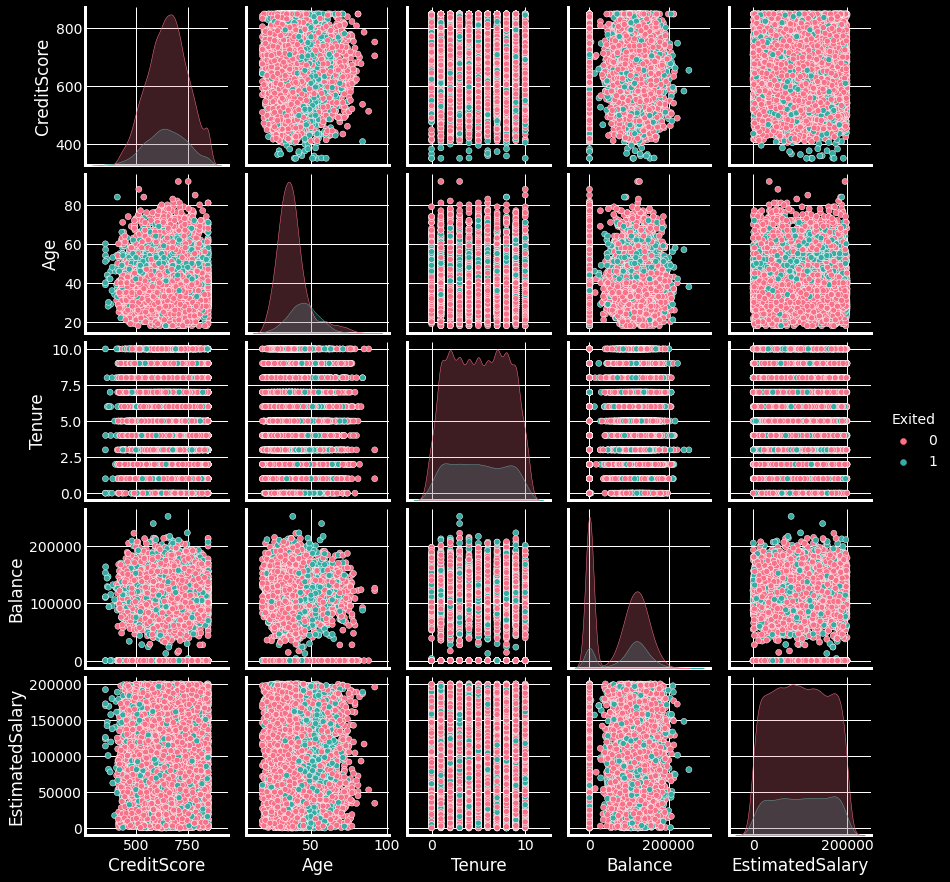

In [19]:
sns.pairplot(plot_data, hue="Exited", palette="husl");

### From above plots we can say there's skewness in the data

## Skewness Correction

In [20]:
def skewnessCorrector(dataset,columnName):
    import seaborn as sns
    from scipy import stats
    from scipy.stats import norm, boxcox
    """
    This function returns two plots distplot and probability plot for non-normalized data and after normalizing the provided data. 
    Just provide it with two parameters dataset and the name of column.
    It corrects the skewness of data applying Boxcox transformation on the provided data
    """
    print('''Before Correcting''')
    (mu, sigma) = norm.fit(dataset[columnName])
    print("Mu before correcting {} : {}, Sigma before correcting {} : {}".format(
        columnName.capitalize(), mu, columnName.capitalize(), sigma))
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.distplot(dataset[columnName], fit=norm, color="lightcoral");
    plt.title(columnName.capitalize() +
              " Distplot before Skewness Correction", color="black")
    plt.subplot(1, 2, 2)
    stats.probplot(dataset[columnName], plot=plt)
    plt.show()
    # Applying BoxCox Transformation
    dataset[columnName], lam_fixed_acidity = boxcox(
        dataset[columnName])
    
    print('''After Correcting''')
    (mu, sigma) = norm.fit(dataset[columnName])
    print("Mu after correcting {} : {}, Sigma after correcting {} : {}".format(
        columnName.capitalize(), mu, columnName.capitalize(), sigma))
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.distplot(dataset[columnName], fit=norm, color="orange");
    plt.title(columnName.capitalize() +
              " Distplot After Skewness Correction", color="black")
    plt.subplot(1, 2, 2)
    stats.probplot(dataset[columnName], plot=plt)
    plt.show()


Before Correcting
Mu before correcting Creditscore : 650.5288, Sigma before correcting Creditscore : 96.64846595037089


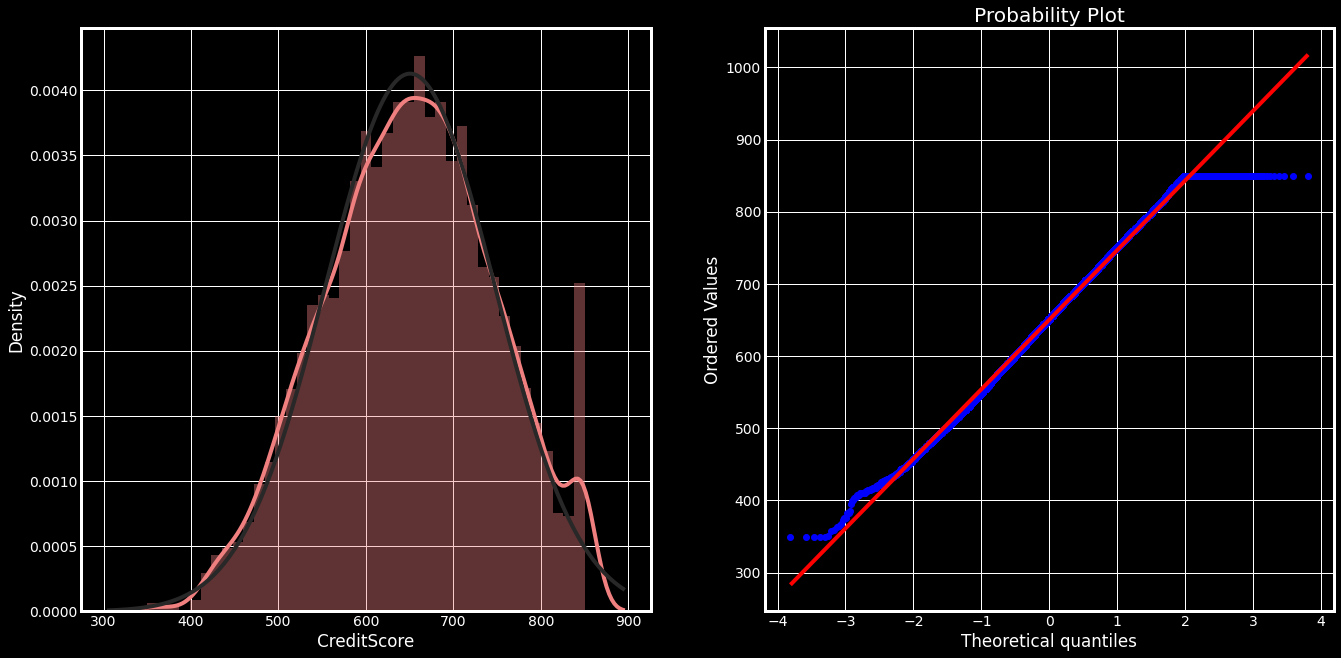

After Correcting
Mu after correcting Creditscore : 1329.0659455133032, Sigma after correcting Creditscore : 222.3060808839672


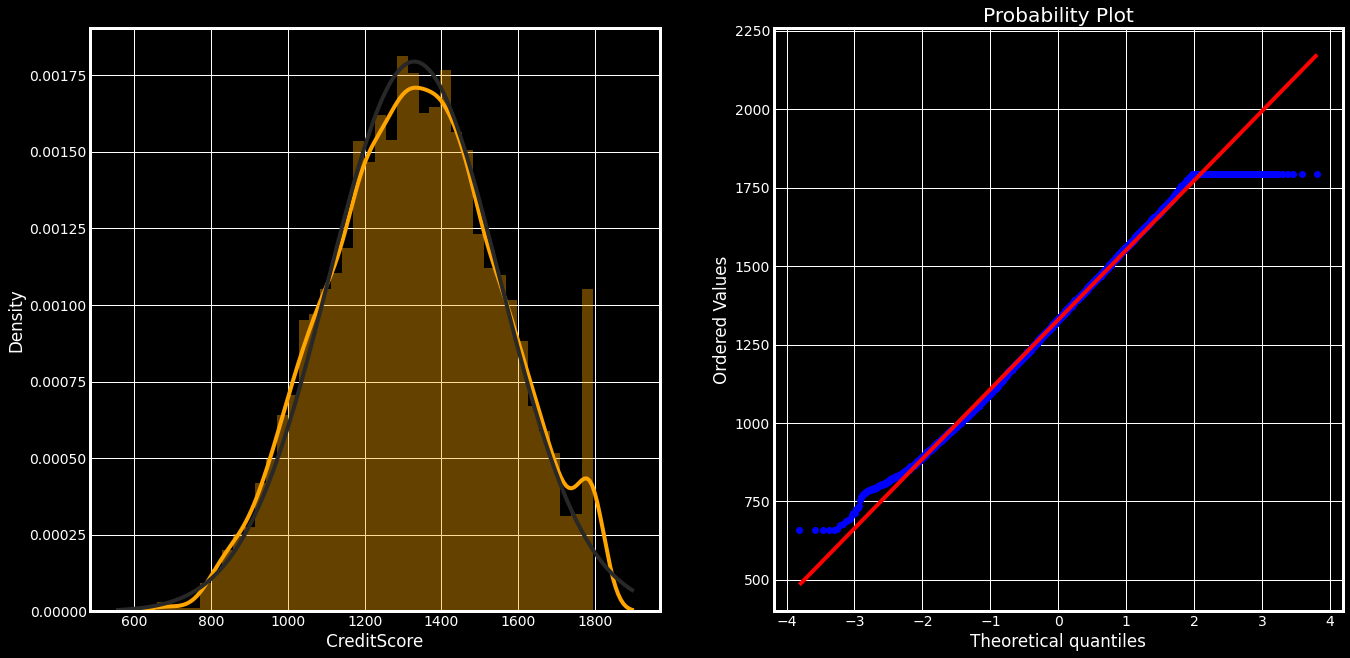

Before Correcting
Mu before correcting Age : 38.9218, Sigma before correcting Age : 10.487282048271611


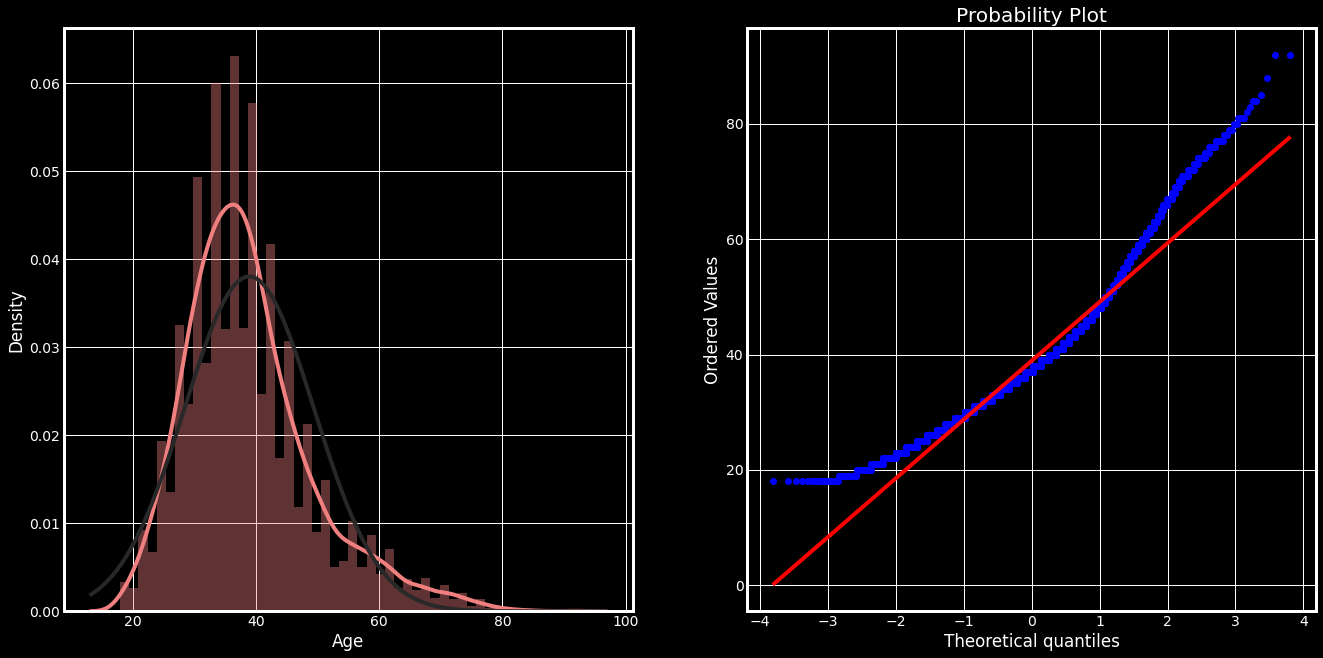

After Correcting
Mu after correcting Age : 2.4793629709576757, Sigma after correcting Age : 0.11426409757988319


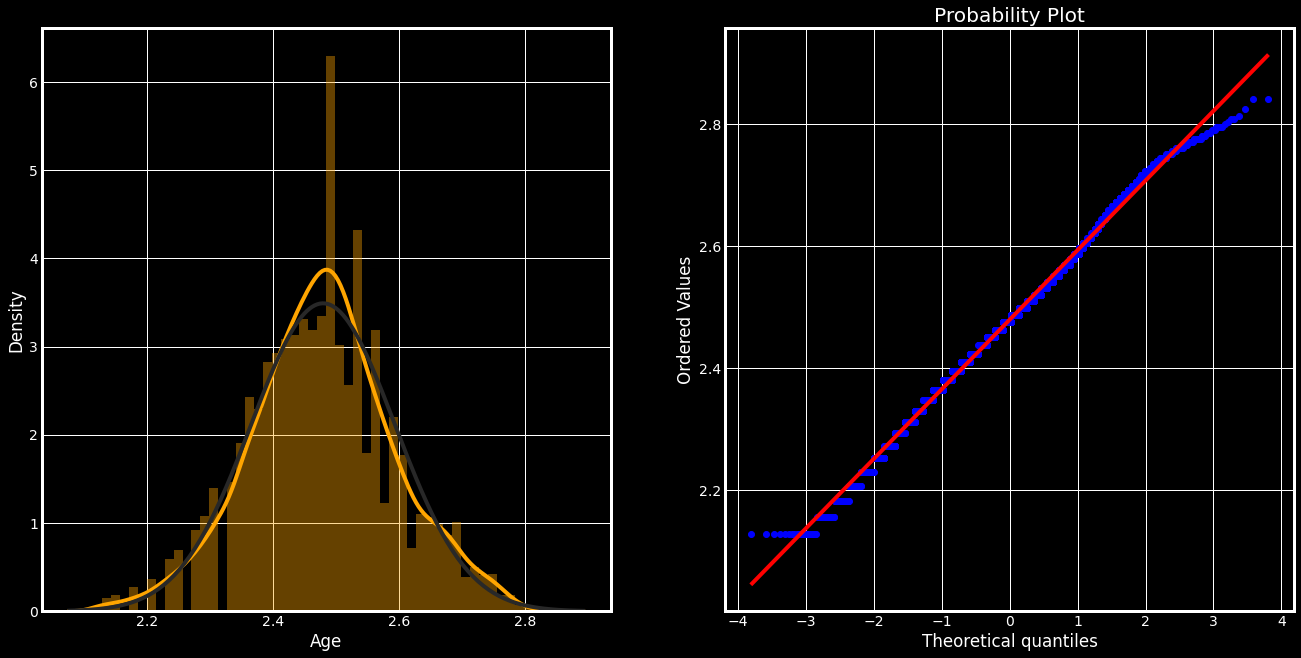

Before Correcting
Mu before correcting Estimatedsalary : 100090.239881, Sigma before correcting Estimatedsalary : 57507.617221165565


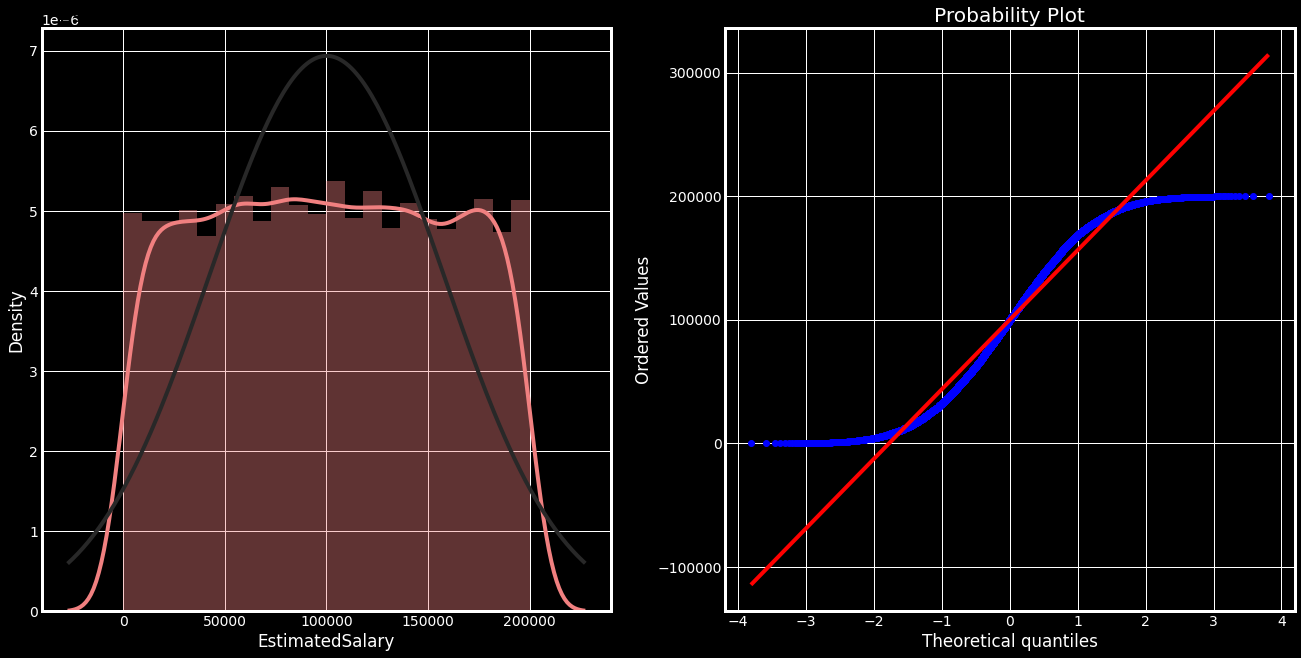

After Correcting
Mu after correcting Estimatedsalary : 4887.519664509259, Sigma after correcting Estimatedsalary : 2224.789051923219


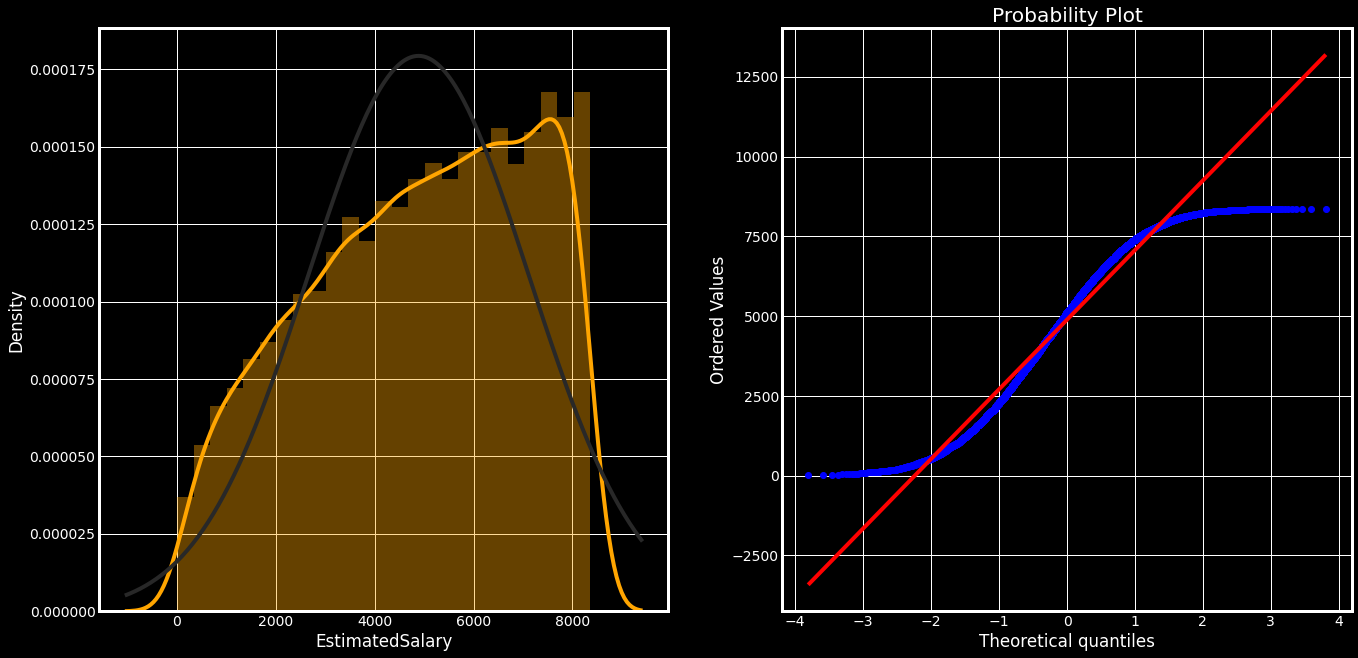

In [21]:
skewed_columns = ['CreditScore', 'Age', 'EstimatedSalary']
for column in skewed_columns:
    skewnessCorrector(dataset,column)

# Data Preprocessing

In [22]:
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

In [23]:
print(X)

[[1254.4947360257115 'France' 'Female' ... 1 1 5151.740581226149]
 [1229.3402503914747 'Spain' 'Female' ... 0 1 5550.872422564284]
 [990.0929623269002 'France' 'Female' ... 1 0 5599.582847657716]
 ...
 [1462.3950616906598 'France' 'Female' ... 0 1 2754.5793966224783]
 [1609.9922354633395 'Germany' 'Male' ... 1 0 4841.598366546475]
 [1657.1803222633757 'France' 'Female' ... 1 0 2570.4376045716594]]


In [24]:
print(y)

[1 0 1 ... 1 1 0]


## Encoding categorical data

### Label Encoding the "Gender" column

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

In [26]:
print(X)

[[1254.4947360257115 'France' 0 ... 1 1 5151.740581226149]
 [1229.3402503914747 'Spain' 0 ... 0 1 5550.872422564284]
 [990.0929623269002 'France' 0 ... 1 0 5599.582847657716]
 ...
 [1462.3950616906598 'France' 0 ... 0 1 2754.5793966224783]
 [1609.9922354633395 'Germany' 1 ... 1 0 4841.598366546475]
 [1657.1803222633757 'France' 0 ... 1 0 2570.4376045716594]]


### One Hot Encoding the "Geography" column

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [28]:
print(X)

[[1.0 0.0 0.0 ... 1 1 5151.740581226149]
 [0.0 0.0 1.0 ... 0 1 5550.872422564284]
 [1.0 0.0 0.0 ... 1 0 5599.582847657716]
 ...
 [1.0 0.0 0.0 ... 0 1 2754.5793966224783]
 [0.0 1.0 0.0 ... 1 0 4841.598366546475]
 [1.0 0.0 0.0 ... 1 0 2570.4376045716594]]


### Splitting the dataset into the Training set and Test set

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 0)

In [30]:
print(X_train)

[[0.0 0.0 1.0 ... 1 0 7252.9373844424135]
 [0.0 1.0 0.0 ... 1 1 3423.27678801075]
 [1.0 0.0 0.0 ... 1 0 7927.85256061261]
 ...
 [1.0 0.0 0.0 ... 1 0 7799.652857118931]
 [0.0 0.0 1.0 ... 1 1 6770.868909724062]
 [0.0 1.0 0.0 ... 1 0 5770.894522028356]]


In [31]:
print(X_test)

[[0.0 1.0 0.0 ... 1 1 8146.312731373235]
 [1.0 0.0 0.0 ... 1 0 6107.507985680157]
 [0.0 0.0 1.0 ... 1 1 4186.198189523151]
 ...
 [0.0 0.0 1.0 ... 1 0 6535.225164860262]
 [0.0 1.0 0.0 ... 1 1 1077.5127136731414]
 [0.0 1.0 0.0 ... 1 0 8149.25872004698]]


In [32]:
print(y_test)

[0 1 0 ... 0 0 0]


In [33]:
print(y_train)

[0 0 0 ... 0 0 1]


## Feature Scaling

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
print(X_train)

[[-1.01460667 -0.5698444   1.74309049 ...  0.64259497 -1.03227043
   1.06117047]
 [-1.01460667  1.75486502 -0.57369368 ...  0.64259497  0.9687384
  -0.65876208]
 [ 0.98560362 -0.5698444  -0.57369368 ...  0.64259497 -1.03227043
   1.36428051]
 ...
 [ 0.98560362 -0.5698444  -0.57369368 ...  0.64259497 -1.03227043
   1.30670495]
 [-1.01460667 -0.5698444   1.74309049 ...  0.64259497  0.9687384
   0.84466949]
 [-1.01460667  1.75486502 -0.57369368 ...  0.64259497 -1.03227043
   0.39557264]]


In [36]:
print(X_test)

[[-1.01460667  1.75486502 -0.57369368 ...  0.64259497  0.9687384
   1.46239279]
 [ 0.98560362 -0.5698444  -0.57369368 ...  0.64259497 -1.03227043
   0.54674856]
 [-1.01460667 -0.5698444   1.74309049 ...  0.64259497  0.9687384
  -0.31612771]
 ...
 [-1.01460667 -0.5698444   1.74309049 ...  0.64259497 -1.03227043
   0.73883992]
 [-1.01460667  1.75486502 -0.57369368 ...  0.64259497  0.9687384
  -1.71226431]
 [-1.01460667  1.75486502 -0.57369368 ...  0.64259497 -1.03227043
   1.46371586]]


# Building the ANN

### Initializing the ANN

In [37]:
ann = tf.keras.models.Sequential()


### Adding the input layer and the first hidden layer

In [38]:
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

### Adding hidden layers

In [39]:
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

In [40]:
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

In [41]:
ann.add(tf.keras.layers.Dense(units = 6, activation = 'relu'))

### Adding the output layer

In [42]:
ann.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

## Training the ANN

### Compiling the ANN

In [43]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'],)

### Training the ANN on the Training set

In [44]:
ann_trained = ann.fit(X_train, y_train,validation_split = 0.20, validation_data = (X_test, y_test), epochs = 100)

Epoch 1/100
200/200 [==============================] - 2s 5ms/step - loss: 0.6086 - accuracy: 0.7851 - val_loss: 0.4987 - val_accuracy: 0.7969
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.7922 - val_loss: 0.4716 - val_accuracy: 0.7969
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.7930 - val_loss: 0.4577 - val_accuracy: 0.7969
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7926 - val_loss: 0.4470 - val_accuracy: 0.7969
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.8001 - val_loss: 0.4416 - val_accuracy: 0.7969
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.7951 - val_loss: 0.4383 - val_accuracy: 0.7969
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.8008 - val_loss: 0.4361 - val_accuracy: 0.7969

## Making the predictions and evaluating the model

### Predicting the result of a single observation

In [45]:
print(ann.predict(sc.transform([[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])) > .5)

[[False]]


Therefore, our ANN model predicts that this customer leaves the bank!

**Important note 1:** Notice that the values of the features were all input in a double pair of square brackets. That's because the "predict" method always expects a 2D array as the format of its inputs. And putting our values into a double pair of square brackets makes the input exactly a 2D array.

**Important note 2:** Notice also that the "France" country was not input as a string in the last column but as "1, 0, 0" in the first three columns. That's because of course the predict method expects the one-hot-encoded values of the state, and as we see in the first row of the matrix of features X, "France" was encoded as "1, 0, 0". And be careful to include these values in the first three columns, because the dummy variables are always created in the first columns.

### Predicting the Test set results

In [46]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


## Plotting Confusion Matrix

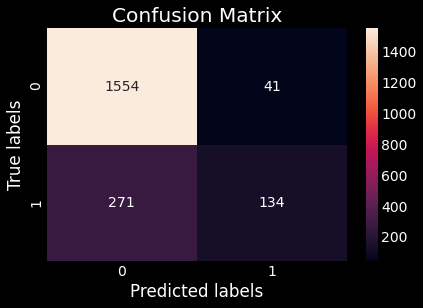

In [47]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); 
ax.yaxis.set_ticklabels(['0', '1']);


## Classification Report

In [48]:
print(classification_report(y_test, y_pred,
          target_names=['0', '1'], zero_division=1))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1595
           1       0.77      0.33      0.46       405

    accuracy                           0.84      2000
   macro avg       0.81      0.65      0.69      2000
weighted avg       0.83      0.84      0.82      2000



In [49]:
print('Accuracy of Model is')
accuracy_score(y_test, y_pred)

Accuracy of Model is


0.844

### Our Ann's Accuracy is 85.95%

# Visualising Our ANN's Loss and Accuracy

In [50]:
def annPlotter(model, plotType):
    plt.figure(figsize = (12, 6))
    if plotType == 'loss':
        param_1 = 'loss'
        param_2 = 'val_loss'
    elif plotType == 'accuracy':
        param_1 = 'accuracy'
        param_2 = 'val_accuracy'
    train = model.history[param_1]
    val = model.history[param_2] 
    epoch = range(1, 101)
    sns.lineplot(epoch, train, label = 'Training '+plotType.capitalize())
    sns.lineplot(epoch, val, label = 'Validation '+plotType.capitalize())
    plt.title('Training and Validation '+plotType.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(plotType.capitalize())
    plt.legend()
    plt.show()

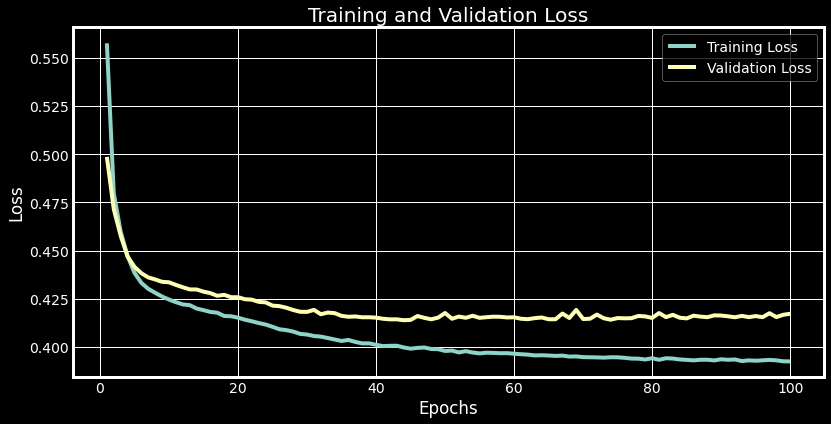

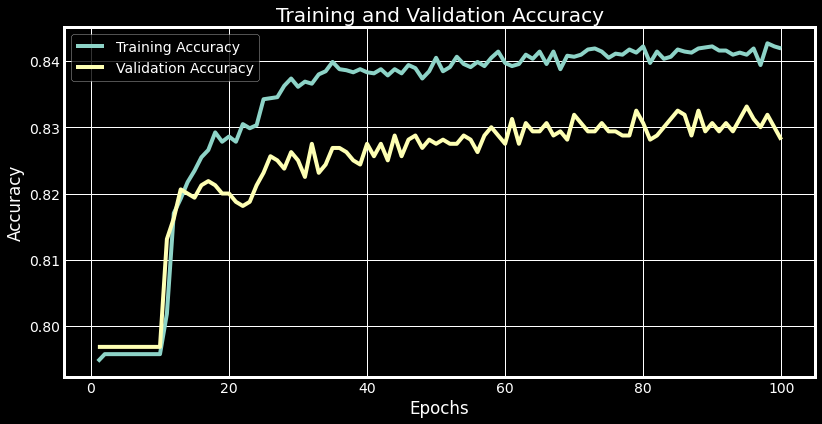

In [51]:
annPlotter(ann_trained, 'loss')
annPlotter(ann_trained, 'accuracy')

## Thanks for Reading
---
## Please share your feedback by commenting below and if you like my work please consider upvoting.